In [39]:
"""

Neural network to classify user
In the case  study of IF29 class
author : Nathan Davouse

"""

import matplotlib.pyplot as plt
#connect from Mongo DB and import it on pandas
from pymongo import MongoClient
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

client = MongoClient("localhost", 27017)
db = client["IF29"]
collec = db.user_label #whole database
data = pd.DataFrame(list(collec.find()))

In [40]:
#Normalize data
features = ["verified", "friend_nb", "listed_nb", "follower_nb", 
            "favorites_nb", "len_description",
            "tweet_nb","hash_avg","at_avg","tweet_user_count",
            'tweet_frequency', 'friend_frequency',"visibility","Aggressivity"]
X = data[features]
Y = data[["label"]]

In [41]:
#normalize data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
# Normalize data
scaler = MinMaxScaler()
scaler.set_output(transform="pandas")
X_sc = scaler.fit_transform(X)

In [42]:
Y["label"].unique()

array([1, 0, 2], dtype=int64)

In [43]:
# remove Vp & Ap from training
X_plot = X_sc[["visibility", "Aggressivity"]].copy()
X_sc_removed = X_sc.drop(["visibility", "Aggressivity"], axis=1)
# Slice and correct label
X_train = X_sc_removed[Y != 1]
Y_train = Y[Y != 1]
Y_train.loc[Y_train.label ==2] = 1
Y_train[Y_train.label == 2] = 1
# Split data


Y_train = Y_train.iloc[:10000]
X_train = X_train.iloc[:10000]

num_twos = (Y_train == 2).sum().item()


# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.30, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train.values)
x_test = torch.FloatTensor(X_test.values)
Y_train = torch.LongTensor(Y_train.values).squeeze()
y_test = torch.LongTensor(Y_test.values).squeeze()

In [44]:
"""Create and train the neural network"""
#héritier de torch.nn.Module
class Model(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_classes):
        super().__init__()
        layers = []
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, output_classes))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [45]:
def train_model(X_train, Y_train, x_test, y_test, model, criterion, optimizer, n_epochs, batch_size):
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(Y_train))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(torch.FloatTensor(x_test), torch.LongTensor(y_test))
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    losses = []
    accuracies_train = []
    accuracies_test = []

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        correct_train = 0
        total_train = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += targets.size(0)
            correct_train += (predicted == targets).sum().item()
        train_accuracy = correct_train / total_train
        accuracies_train.append(train_accuracy)
        
        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_test += targets.size(0)
                correct_test += (predicted == targets).sum().item()
            test_accuracy = correct_test / total_test
            accuracies_test.append(test_accuracy)
        
        losses.append(epoch_loss / len(train_loader))
        # Affichage de l'epoch, précisions (accuracies) et perte (loss) sur la même ligne
        print(f"Epoch [{epoch+1}/{n_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Loss: {losses[-1]:.4f}")

    return losses, accuracies_train, accuracies_test

In [46]:
#Paramétrage    
input_size = X_sc_removed.shape[1]
hidden_size = [100, 50, 20]
n_epochs = 150
batch_size = 64

output_classes = len(np.unique(data['label']))


In [47]:
#création du modèle
model = Model(input_size, hidden_size, output_classes)
type(model)


__main__.Model

In [48]:
#optimisation modèle
criterion = torch.nn.CrossEntropyLoss()
#critere_ps = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [49]:
#entrainement du modèle
losses, accuracies_train, accuracies_test = train_model(X_train, Y_train, x_test, y_test, model, criterion, optimizer, n_epochs, batch_size)

IndexError: Target -9223372036854775808 is out of bounds.

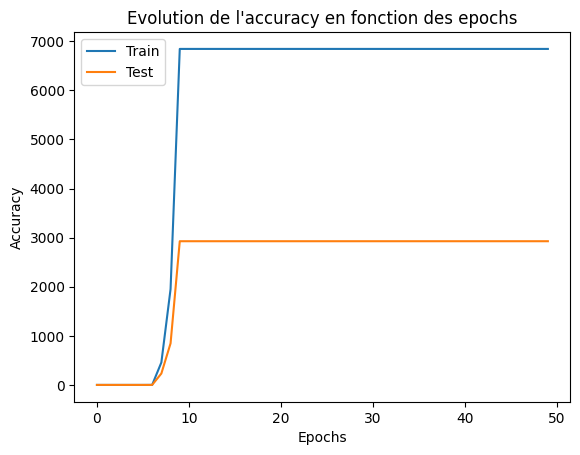

In [ ]:
# Plot loss and accuracies
plt.plot(np.arange(1, n_epochs+1), losses, label='Loss')
plt.plot(np.arange(1, n_epochs+1), accuracies_train, label='Train Accuracy')
plt.plot(np.arange(1, n_epochs+1), accuracies_test, label='Test Accuracy')
plt.title("Training Progress")
plt.xlabel("Epoch")
plt.legend()
plt.show()